In [2]:
# Cell [0]
# ======================================
# 1. Install/Import Required Libraries
# ======================================

import pandas as pd
from google_play_scraper import Sort, reviews
import subprocess
from tqdm import tqdm

In [3]:
# Cell [1]
# ======================================
# 2. Define Parameters
# ======================================

# Package name of the BMW app on Google Play:
app_id = "de.bmw.connected.mobile20.row"

# Ollama model
ollama_model_name = "llama3.2:3b-instruct-fp16"

# Prompt template for sentiment classification.
ollama_prompt_template = """You are a sentiment classifier. Classify the sentiment of the following text as Positive, Negative, or Neutral. Do not add any additional information.
Text: "{review_text}"
Answer:
"""

In [4]:
# Cell [2]
# ======================================
# 3. Fetch Reviews from Google Play Store
# ======================================

# Define languages to fetch (just language codes and labels)
languages = [
    ('en', 'English'),
    ('de', 'German'),
    ('fr', 'French'),
    ('it', 'Italian'),
    ('es', 'Spanish'),
    ('nl', 'Dutch'),
    ('sv', 'Swedish'),
    ('da', 'Danish'),
    ('no', 'Norwegian'),
    ('fi', 'Finnish'),
    ('pl', 'Polish'),
    ('cs', 'Czech'),
    ('pt', 'Portuguese'),
    ('zh', 'Chinese'),
    ('ja', 'Japanese'),
    ('ko', 'Korean'),
    ('ar', 'Arabic'),
    ('tr', 'Turkish'),
    ('ru', 'Russian'),
    ('he', 'Hebrew'),
    ('th', 'Thai'),
    ('vi', 'Vietnamese'),
    ('hi', 'Hindi'),
    ('el', 'Greek'),
    ('hu', 'Hungarian'),
    ('ro', 'Romanian'),
    ('sk', 'Slovak'),
    ('bg', 'Bulgarian'),
    ('hr', 'Croatian'),
    ('sr', 'Serbian'),
    ('uk', 'Ukrainian'),
    ('id', 'Indonesian'),
    ('ms', 'Malay'),
    ('fa', 'Persian'),
    ('ur', 'Urdu'),
    ('bn', 'Bengali'),
    ('ta', 'Tamil'),
    ('te', 'Telugu'),
    ('ml', 'Malayalam'),
    ('et', 'Estonian'),
    ('lv', 'Latvian'),
    ('lt', 'Lithuanian'),
    ('sl', 'Slovenian')
]

# Initialize empty list to store all reviews
all_reviews = []

# Fetch reviews for each language
for lang_code, lang_label in languages:
    continuation_token = None
    prev_length = len(all_reviews)
    
    while True:
        result, continuation_token = reviews(
            app_id,
            lang=lang_code,
            sort=Sort.NEWEST,
            count=100,
            continuation_token=continuation_token
        )
        
        # Add language label to each review
        for review in result:
            review['language'] = lang_label
        
        all_reviews.extend(result)
        
        # Break if no more reviews or if number of reviews isn't increasing
        current_length = len(all_reviews)
        if not continuation_token or current_length - prev_length < 100:
            break
            
        prev_length = current_length

# Convert all reviews into a pandas DataFrame
df = pd.DataFrame(all_reviews)

print("\nReview Statistics:")
print("=" * 50)
print(f"Total number of reviews collected: {len(df)}")
print("\nBreakdown by language:")
print("-" * 50)
language_counts = df['language'].value_counts()
print(language_counts)
print("-" * 50)
print(f"Number of languages with reviews: {len(language_counts)}")
# Inspect the first few rows
df.head()


Review Statistics:
Total number of reviews collected: 17768

Breakdown by language:
--------------------------------------------------
language
German        4796
English       4482
French        1631
Italian       1280
Dutch          932
Spanish        929
Polish         618
Portuguese     561
Russian        461
Romanian       271
Swedish        255
Norwegian      199
Japanese       198
Finnish        170
Czech          152
Greek          112
Hungarian      109
Danish         102
Thai            96
Croatian        62
Slovak          55
Turkish         53
Slovenian       51
Chinese         46
Bulgarian       42
Arabic          28
Serbian         19
Ukrainian       12
Lithuanian      12
Estonian         9
Latvian          7
Indonesian       6
Korean           5
Hebrew           4
Malay            2
Persian          1
Name: count, dtype: int64
--------------------------------------------------
Number of languages with reviews: 36


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,language
0,fbf9a2fc-22b7-4dcb-a868-a2ff192412bd,Rory Neill,https://play-lh.googleusercontent.com/a-/ALV-U...,Covers all the information and guidance you co...,5,0,4.11.4,2025-02-12 12:12:07,None,NaT,4.11.4,English
1,acf25595-4394-4c69-9aa7-b813400592ad,Francesco Berto,https://play-lh.googleusercontent.com/a-/ALV-U...,App doesn't detect anymore when car is plugged...,2,0,4.11.4,2025-02-11 00:31:27,Hi Francesco! We regret that you are experienc...,2025-02-12 12:00:56,4.11.4,English
2,41b28479-d089-4c30-9f6e-6482c3dd0688,Bryan Hitchman,https://play-lh.googleusercontent.com/a/ACg8oc...,Brilliant .,5,0,4.11.4,2025-02-10 22:36:06,None,NaT,4.11.4,English
3,d0bb097c-1072-483e-8524-ccd124e05b43,mathew cavanagh,https://play-lh.googleusercontent.com/a/ACg8oc...,if you have a bmw get this,5,0,4.11.4,2025-02-08 23:18:55,None,NaT,4.11.4,English
4,c2a11ca5-6b4f-4155-ae14-96b927c07c19,Hina Paw,https://play-lh.googleusercontent.com/a/ACg8oc...,brilliant app!,5,0,4.11.4,2025-02-08 10:09:46,None,NaT,4.11.4,English


In [5]:
# Cell [3]
# ======================================
# 4. Sample Reviews
# ======================================
# After creating the initial DataFrame, add this line to sample 500 random reviews
df2 = df.sample(n=500, random_state=42)  # random_state ensures reproducibility
print(f"Sampled {len(df2)} random reviews for analysis")

Sampled 500 random reviews for analysis


In [6]:
# Cell [4]
# ======================================
# 5. Translate Non-English Reviews
# ======================================

def translate_text(text, source_lang, ollama_model_name):
    """
    Translate text to English using Ollama.
    
    :param text: Text to translate
    :param source_lang: Source language label (e.g., 'German', 'French')
    :param ollama_model_name: Name of the Ollama model to use
    :return: Translated text
    """
    prompt = f"""You are a translator. Translate the following {source_lang} text to English.
Only provide the translation, no additional information.
Text: "{text}"
Translation:"""
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

# Create a copy of the original content
df2['content_english'] = df2['content']

# Translate non-English reviews
for idx in tqdm(df2[df2['language'] != 'English'].index, desc="Translating reviews"):
    original_text = df2.loc[idx, 'content']
    source_lang = df2.loc[idx, 'language']
    
    translated_text = translate_text(original_text, source_lang, ollama_model_name)
    df2.loc[idx, 'content_english'] = translated_text

# Display a few examples of translated reviews
print("\nExample translations:")
print(df2[['language', 'content', 'content_english']].head(3))

Translating reviews: 100%|██████████| 373/373 [06:53<00:00,  1.11s/it]


Example translations:
      language                                            content  \
1086   English  It would be so nice if I could set the units i...   
16737  Russian  Сначала не возможно зарегистрироваться было,по...   
4105   English  Please add the option to change units to metri...   

                                         content_english  
1086   It would be so nice if I could set the units i...  
16737  At first it was not possible to register, the ...  
4105   Please add the option to change units to metri...  


In [7]:
# Cell [5]
# ======================================
# 6. Display Translation Results
# ======================================

# Set display options to show full content
pd.set_option('display.max_colwidth', None)  # Show full column content
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.width', None)         # Don't wrap to new lines

# Print rows 6000 to 6010 with specified columns
print(df2[['language', 'content', 'content_english']].head(10))

# Reset display options to default (optional)
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

      language  \
1086   English   
16737  Russian   
4105   English   
2684   English   
13028  Spanish   
11784  Italian   
11604  Italian   
9321    French   
736    English   
101    English   

                                                                                                                                                                                                                                                                                                                   content  \
1086                                                                                                                                                   It would be so nice if I could set the units in the app. I use my phone in English but I leave in a km county and now the app shows me miles instead of kilometers.   
16737  Сначала не возможно зарегистрироваться было,постоянно сброс на стартовую страницу приложения шел.потом всё-таки программа пустила,пару месяцев работало более 

In [8]:
# Cell [6]
# ======================================
# 7. Define Sentiment Analysis Function
# ======================================

def get_sentiment_from_ollama(text, model_name=ollama_model_name):
    
    # Use the English translation for non-English reviews
    text_to_analyze = text['content_english'] if isinstance(text, pd.Series) else text
    
    # Prepare the prompt by injecting our text into the template
    prompt = ollama_prompt_template.format(review_text=text_to_analyze)
    
    # Use subprocess.run to call Ollama
    process = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    # Ollama's output is in process.stdout
    output = process.stdout.strip()

    return output

In [9]:
# Cell [7]
# ======================================
# 8. Run Sentiment Analysis
# ======================================

# Print total number of reviews before starting
total_reviews = len(df2)
print(f"Starting sentiment analysis on {total_reviews} reviews...")

sentiments = []
for idx, row in tqdm(df2.iterrows(), 
                     desc="Analyzing Sentiment", 
                     total=total_reviews,
                     position=0):
    sentiment_label = get_sentiment_from_ollama(row)
    sentiments.append(sentiment_label)
    
    # Print progress every 100 reviews
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{total_reviews} reviews")

# Add the sentiments to the DataFrame
df2['sentiment'] = sentiments

# Print final count
print(f"\nCompleted sentiment analysis on {len(sentiments)} reviews")

Starting sentiment analysis on 500 reviews...


Analyzing Sentiment:  23%|██▎       | 113/500 [00:21<01:12,  5.33it/s]

Processed 9000/500 reviews


Analyzing Sentiment:  60%|█████▉    | 299/500 [00:54<00:33,  5.92it/s]

Processed 16500/500 reviews


Analyzing Sentiment:  94%|█████████▍| 469/500 [01:24<00:05,  5.53it/s]

Processed 16300/500 reviews


Analyzing Sentiment: 100%|██████████| 500/500 [01:30<00:00,  5.53it/s]


Completed sentiment analysis on 500 reviews


Sentiment Distribution:
sentiment
Negative    240
Positive    196
Neutral      64
Name: count, dtype: int64


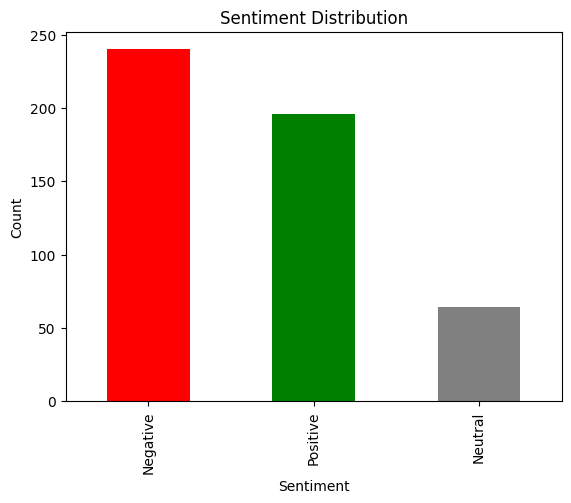

In [10]:
# Cell [8]
# ======================================
# 9. Analyze Sentiment Distribution
# ======================================

# Count how many times each sentiment occurs
sentiment_counts = df2['sentiment'].value_counts()

print("Sentiment Distribution:")
print(sentiment_counts)

# Define a color map for each sentiment
sentiment_color_dict = {
    "Positive": "green",
    "Negative": "red",
    "Neutral": "gray"
}

# Create a list of colors
color_list = [sentiment_color_dict.get(label, "blue") for label in sentiment_counts.index]

# Create the bar plot
ax = sentiment_counts.plot(
    kind='bar', 
    title='Sentiment Distribution', 
    xlabel='Sentiment', 
    ylabel='Count',
    color=color_list
)

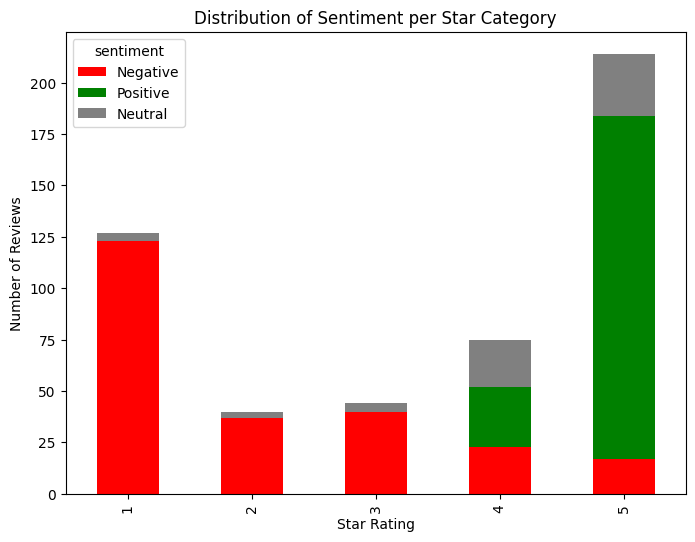

In [11]:
# Cell [9]
# ======================================
# 10. Plot Sentiment per Star Rating
# ======================================

import matplotlib.pyplot as plt

# Group by 'score' (star rating) and 'sentiment', then count how many reviews
grouped = df2.groupby(['score', 'sentiment']).size().unstack(fill_value=0)

# Reorder the columns
column_order = ['Negative', 'Positive', 'Neutral']
grouped = grouped.reindex(columns=column_order, fill_value=0)

# Plot as a stacked bar chart
ax = grouped.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8, 6),
    title='Distribution of Sentiment per Star Category',
    color=color_list
)

ax.set_xlabel('Star Rating')
ax.set_ylabel('Number of Reviews')

plt.show()

In [12]:
# Cell [10]
# ======================================
# 11. Analyze One-Star Reviews
# ======================================

import subprocess

def summarize_complaints(text, ollama_model_name):

    prompt = f"""You are a helpful assistant.
The following text contains users' complaints about a mobile application.
Please provide a concise summary of the main issues that users are complaining about.
Text:
{text}
Summary:"""
    
    process = subprocess.run(
        ["ollama", "run", ollama_model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()

# Filter 1-star reviews
one_star_df = df2[df2['score'] == 1].copy()

# Combine all 1-star reviews into a single string
complaints_combined = " ".join(one_star_df['content_english'].tolist())

# Call the summarization function
summary_of_complaints = summarize_complaints(complaints_combined, ollama_model_name)
print("Summary of 1-Star Complaints:\n", summary_of_complaints)

Summary of 1-Star Complaints:
 It seems like you've compiled a comprehensive list of complaints about the BMW Connected Drive app from various users. Here's a summary:

**Common Issues:**

1. **App crashes**: Frequent crashes, freezes, or hangs on Android devices.
2. **Connection problems**: Users can't connect to their vehicles, making it impossible to access features like remote start, unlock doors, or flash headlights.
3. **Data synchronization issues**: Updates not synchronizing with vehicle data, such as tire pressure, fuel level, or vehicle location.
4. **Registration and login problems**: Users need to re-register or log in repeatedly due to system errors or forgotten passwords.

**Specific Problems:**

1. **Navigation issues**: Issues with Here Maps integration, including failure to find places, incorrect directions, and outdated data (reported on 23.2.22).
2. **Alexa integration**: Music streaming doesn't work as expected, with some users reporting "Service not set up" errors.

In [13]:
# Cell [11]
# ======================================
# 12. Define Topic Categories
# ======================================

# First, let's define our potential topics
REVIEW_TOPICS = """
1. UI/UX:
   - User interface, app design, ease of use, navigation, overall visual appeal.
2. Performance:
   - App speed, crashes, bugs, stability, battery drain.
3. Connectivity:
   - Connection issues, Bluetooth, server problems, integration with external devices.
4. Authentication:
   - Login issues, account problems, multi-factor authentication, session timeouts.
5. Vehicle Status:
   - Battery, fuel, location, diagnostics.
6. Remote Controls:
   - Lock/unlock, climate control, remote start.
7. Trip Planning:
   - Route optimization, scheduling, and related features.
8. Charging Management:
   - Charging status, locating charging stations, scheduling.
9. Map/Navigation:
   - Maps functionality, route planning, GPS accuracy, alternative route suggestions.
10. Mobile Features:
   - Widgets, notifications, mobile-specific interactions, quick-access features.
11. Data & Privacy:
   - Data handling, privacy concerns, data sharing, security practices.
12. Updates:
   - App updates, version issues, patch notes, update-related bugs.
13. Feature Requests:
    - Desired new functionality, user suggestions for enhancements.
14. Customer Support:
    - Support experience, response time, issue resolution, helpdesk effectiveness.
15. Connected Store:
    - In-app store experience, product browsing, payment process, promotional offers, purchase issues, ease of transaction.
16. BMW Digital Premium:
    - Subscription service experience, access to premium features, content quality, subscription pricing, management of subscription settings.
"""

def label_review_topics(text, model_name=ollama_model_name):
    """
    Label a review with relevant topics using Ollama.
    
    :param text: Review text to analyze
    :param model_name: Ollama model name
    :return: List of identified topics
    """
    prompt = f"""You are a review topic classifier. Given the following review, identify ALL relevant topics it discusses.
Use ONLY the topics from this list:
{REVIEW_TOPICS}

Review text: "{text}"

Output the topics as a simple comma-separated list, with no additional text or explanations.
If you are not sure about the topics, output the word "Other". It can be due to the review being too short or unclear, empty or not related to the app.
Example output: UI/UX, Performance, Core Features (Vehicle Status)"""
    
    process = subprocess.run(
        ["ollama", "run", model_name],
        input=prompt,
        text=True,
        capture_output=True
    )
    
    return process.stdout.strip()


In [14]:
# Cell [12]
# ======================================
# 13. Apply Topic Labeling
# ======================================

print("Starting topic analysis...")
topics = []
for idx, row in tqdm(df2.iterrows(), 
                     desc="Analyzing Topics", 
                     total=len(df2),
                     position=0):
    # Use English content for consistency
    review_topics = label_review_topics(row['content_english'])
    topics.append(review_topics)
    
    # Print progress every 100 reviews
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(df2)} reviews")

# Add topics to DataFrame
df2['topics'] = topics

Starting topic analysis...


Analyzing Topics:  22%|██▏       | 112/500 [00:52<02:47,  2.31it/s]

Processed 9000/500 reviews


Analyzing Topics:  60%|█████▉    | 299/500 [02:07<01:28,  2.27it/s]

Processed 16500/500 reviews


Analyzing Topics:  94%|█████████▎| 468/500 [03:19<00:16,  1.89it/s]

Processed 16300/500 reviews


Analyzing Topics: 100%|██████████| 500/500 [03:33<00:00,  2.34it/s]


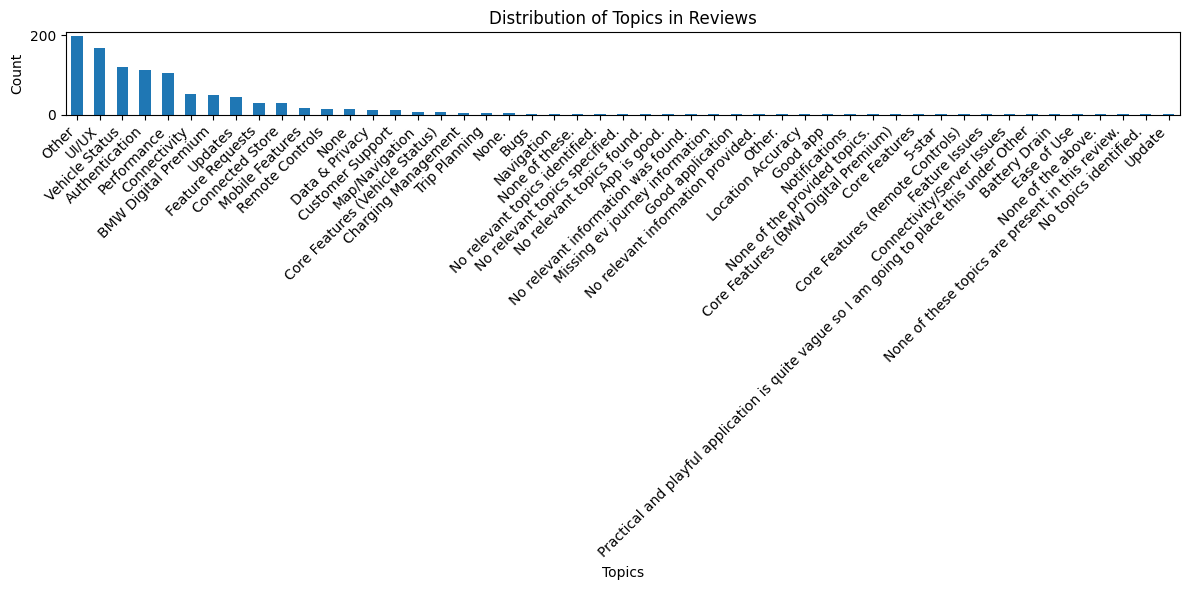

In [15]:
# Cell [13]
# ======================================
# 14. Analyze Topic Distribution
# ======================================

# Split the comma-separated topics and create a flat list
all_topics = []
for topic_list in df2['topics']:
    topics = [t.strip() for t in topic_list.split(',')]
    all_topics.extend(topics)

# Count topic frequencies
topic_counts = pd.Series(all_topics).value_counts()

# Plot topic distribution
plt.figure(figsize=(12, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Topics in Reviews')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

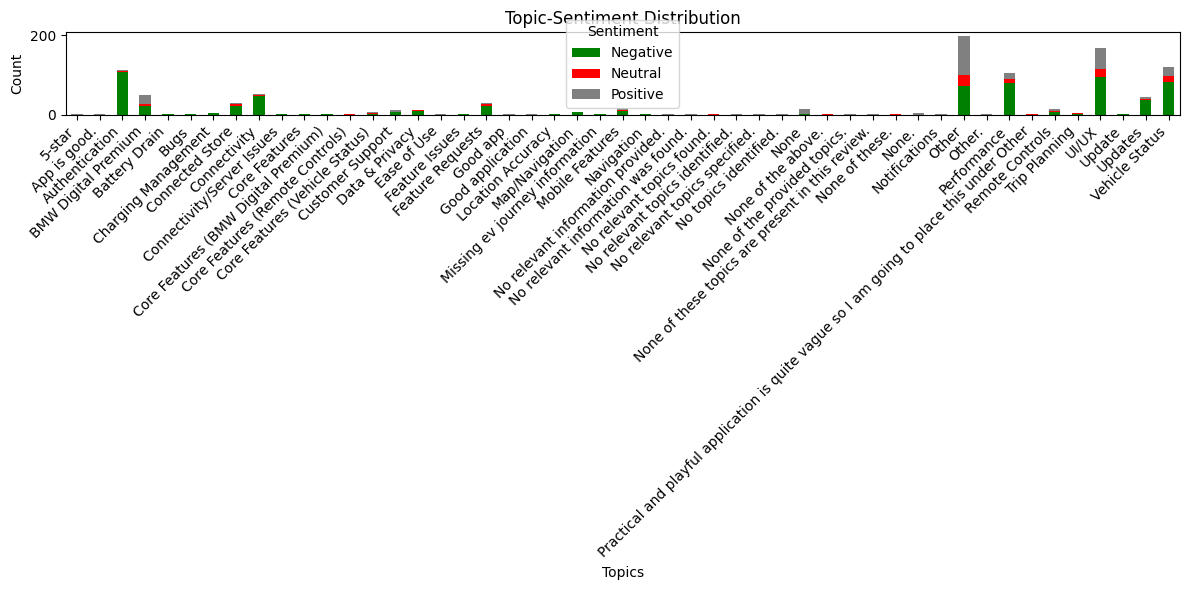

In [16]:
# Cell [14]
# ======================================
# 15. Topic-Sentiment Relationship Analysis
# ======================================

# Create a DataFrame with topic-sentiment combinations
topic_sentiment_data = []
for _, row in df2.iterrows():
    topics = [t.strip() for t in row['topics'].split(',')]
    for topic in topics:
        topic_sentiment_data.append({
            'topic': topic,
            'sentiment': row['sentiment']
        })

topic_sentiment_df = pd.DataFrame(topic_sentiment_data)

# Create a pivot table
topic_sentiment_pivot = pd.pivot_table(
    topic_sentiment_df,
    index='topic',
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)

# Plot stacked bar chart
topic_sentiment_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=['green', 'red', 'gray']
)
plt.title('Topic-Sentiment Distribution')
plt.xlabel('Topics')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_9903/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_9903/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_9903/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_9903/2248496748.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  topic_o

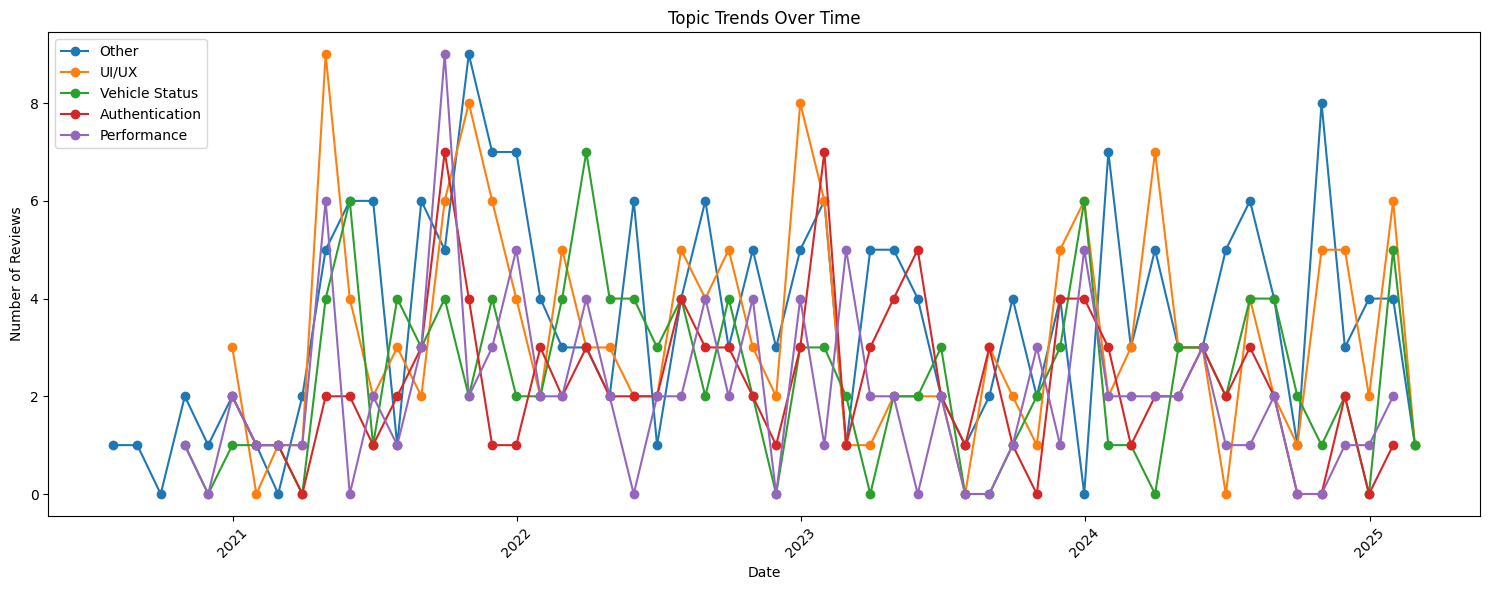

In [17]:
# Cell [15]
# ======================================
# 16. Time-Based Analysis
# ======================================

# Convert 'at' column to datetime if not already
df2['at'] = pd.to_datetime(df2['at'])

# Analyze topic trends over time
def plot_topic_trends():
    # Resample by month and count topics
    monthly_topics = []
    for topic in topic_counts.index[:5]:  # Top 5 most common topics
        topic_over_time = df2[df2['topics'].str.contains(topic)].resample('M', on='at').size()
        monthly_topics.append((topic, topic_over_time))
    
    # Plot
    plt.figure(figsize=(15, 6))
    for topic, data in monthly_topics:
        plt.plot(data.index, data.values, label=topic, marker='o')
    
    plt.title('Topic Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_topic_trends()

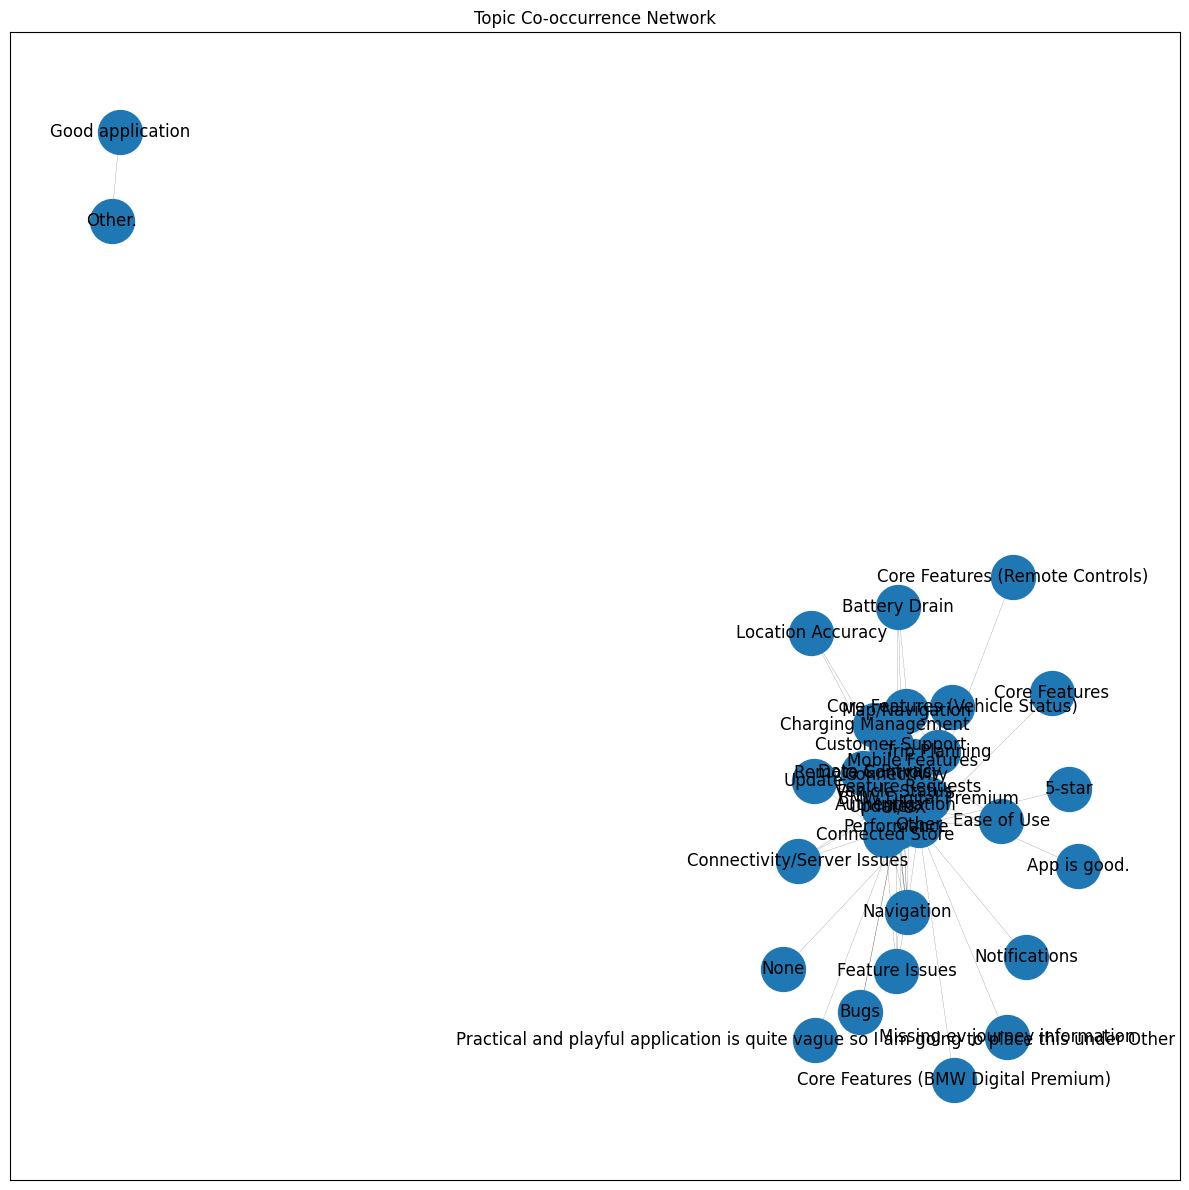

In [18]:
# Cell [16]
# ======================================
# 17. Topic Co-occurrence Analysis
# ======================================

from itertools import combinations
import networkx as nx

def analyze_topic_cooccurrence():
    # Create co-occurrence matrix
    topic_pairs = []
    for topics in df2['topics']:
        topic_list = [t.strip() for t in topics.split(',')]
        topic_pairs.extend(combinations(sorted(set(topic_list)), 2))
    
    cooccurrence = pd.Series(topic_pairs).value_counts()
    
    # Create network graph
    G = nx.Graph()
    for (topic1, topic2), weight in cooccurrence.items():
        G.add_edge(topic1, topic2, weight=weight)
    
    # Plot
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000)
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']/10 for u,v in G.edges()])
    nx.draw_networkx_labels(G, pos)
    plt.title('Topic Co-occurrence Network')
    plt.tight_layout()
    plt.show()

analyze_topic_cooccurrence()

/var/folders/t5/c04zc7dn6g5bd523j9fhp2040000gn/T/ipykernel_9903/917356870.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(regional_analysis['language'], rotation=45)


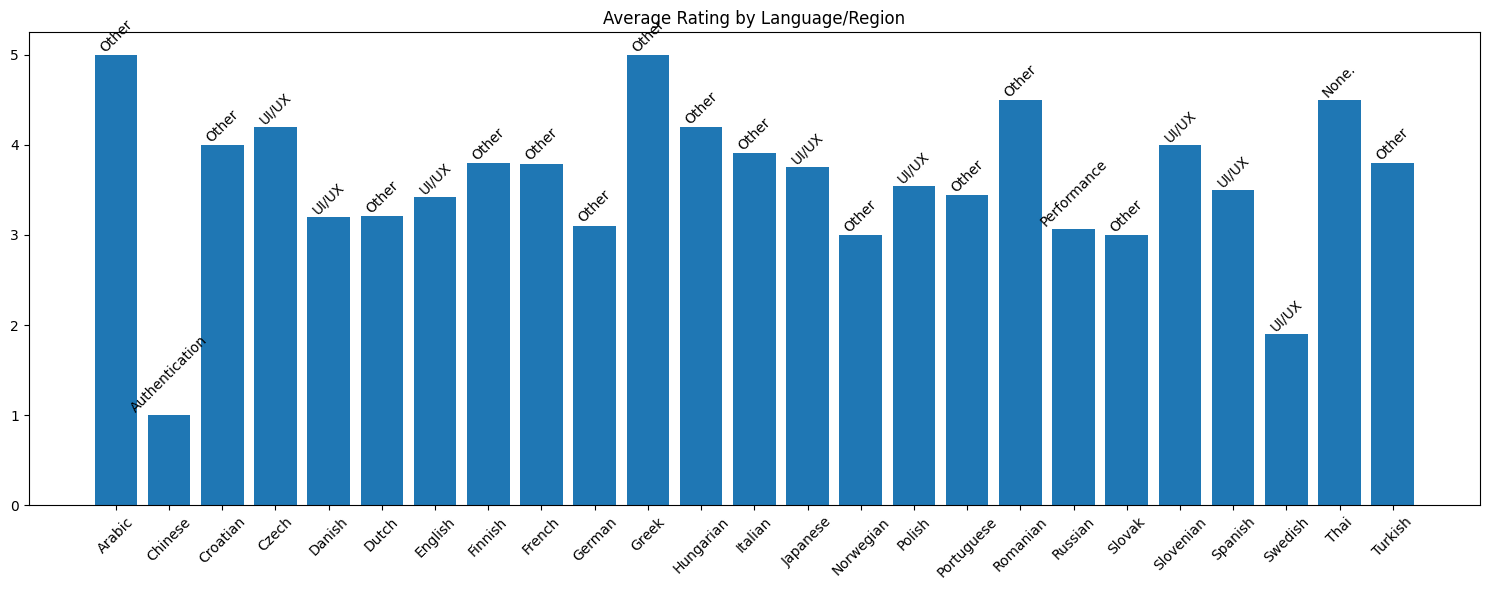

In [19]:
# Cell [17]
# ======================================
# 18. Language/Region Analysis
# ======================================

def analyze_regional_differences():
    # Calculate average ratings and most common topics by language
    regional_analysis = df2.groupby('language').agg({
        'score': 'mean',
        'topics': lambda x: pd.Series([t.strip() for topics in x for t in topics.split(',')]).value_counts().index[0]
    }).reset_index()
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    bars = ax.bar(regional_analysis['language'], regional_analysis['score'])
    ax.set_title('Average Rating by Language/Region')
    ax.set_xticklabels(regional_analysis['language'], rotation=45)
    
    # Add most common topic as text on top of each bar
    for idx, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            regional_analysis.iloc[idx]['topics'],
            ha='center',
            va='bottom',
            rotation=45
        )
    
    plt.tight_layout()
    plt.show()

analyze_regional_differences()

Available columns in df2: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'language', 'content_english', 'sentiment', 'topics']


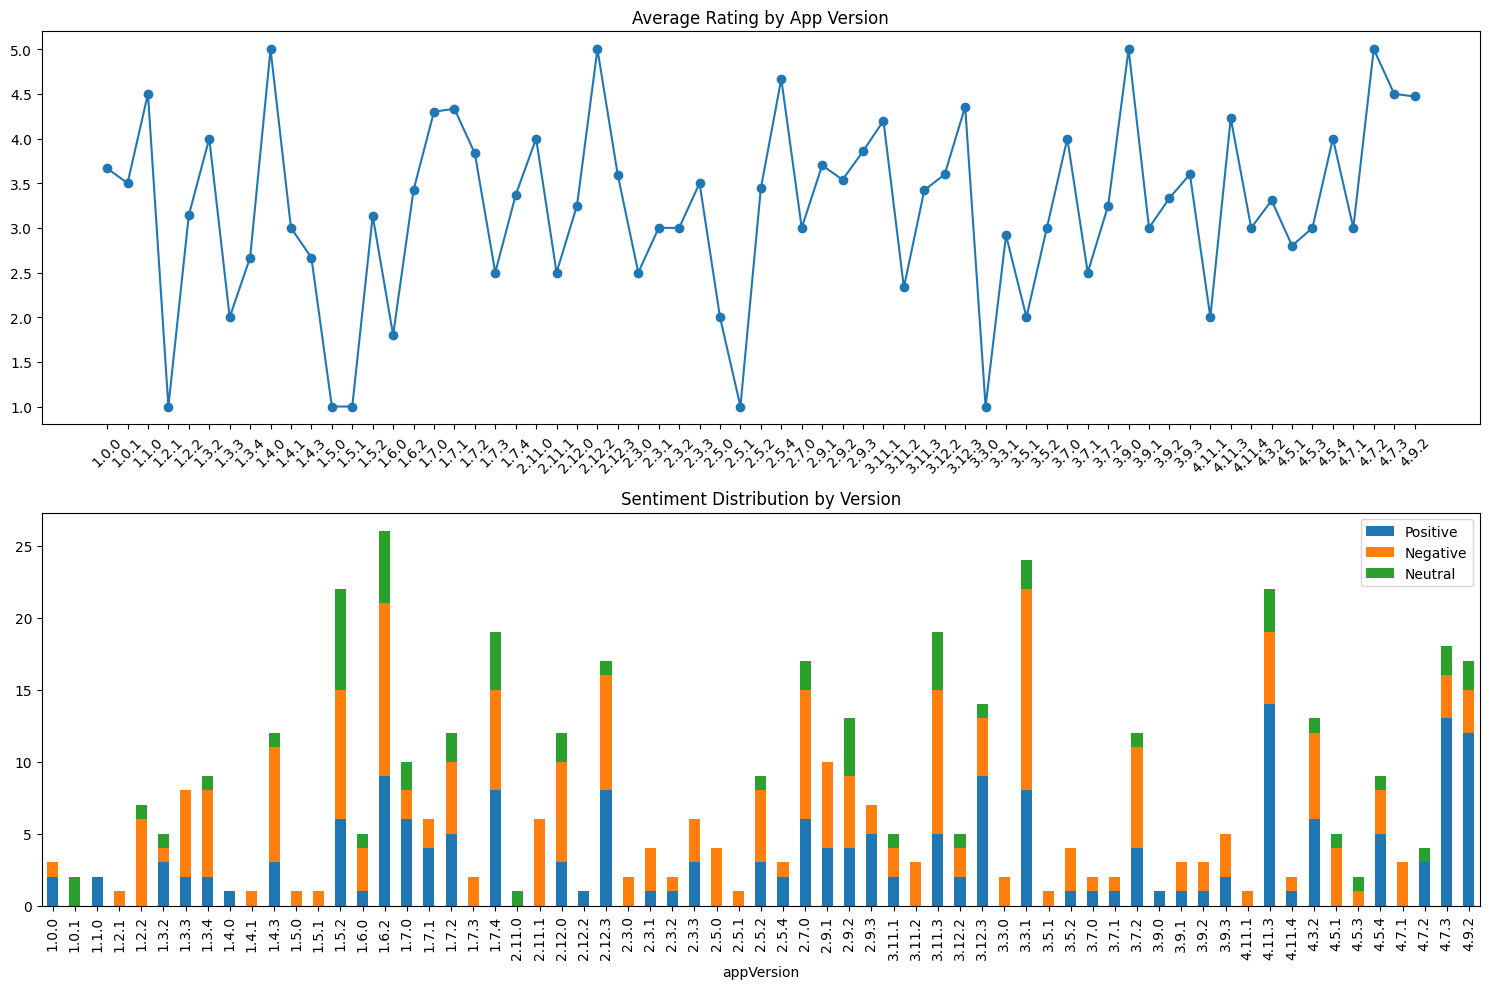

In [20]:
# Cell [18]
# ======================================
# 19. Version-Based Analysis
# ======================================

def analyze_version_impact():
    # First, check if we have version information in the DataFrame
    if 'version' not in df2.columns:
        # Try to use 'appVersion' or other possible column names
        version_column = 'appVersion' if 'appVersion' in df2.columns else None
        if version_column is None:
            print("No version information found in the DataFrame")
            print("Available columns:", df2.columns.tolist())
            return
    else:
        version_column = 'version'

    # Group by version and calculate average score and sentiment distribution
    version_analysis = df2.groupby(version_column).agg({
        'score': 'mean',
        'sentiment': lambda x: x.value_counts().to_dict()
    }).reset_index()
    
    # Sort by version number (assuming semantic versioning)
    version_analysis = version_analysis.sort_values(version_column)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Average score by version
    ax1.plot(version_analysis[version_column], version_analysis['score'], marker='o')
    ax1.set_title('Average Rating by App Version')
    ax1.set_xticks(range(len(version_analysis[version_column])))
    ax1.set_xticklabels(version_analysis[version_column], rotation=45)
    
    # Sentiment distribution by version
    sentiments_by_version = pd.DataFrame([
        {**{version_column: v}, **s}
        for v, s in zip(version_analysis[version_column], version_analysis['sentiment'])
    ]).fillna(0)
    
    sentiments_by_version.plot(x=version_column, kind='bar', stacked=True, ax=ax2)
    ax2.set_title('Sentiment Distribution by Version')
    plt.tight_layout()
    plt.show()

# Let's first check what columns we have in the DataFrame
print("Available columns in df2:", df2.columns.tolist())

analyze_version_impact()

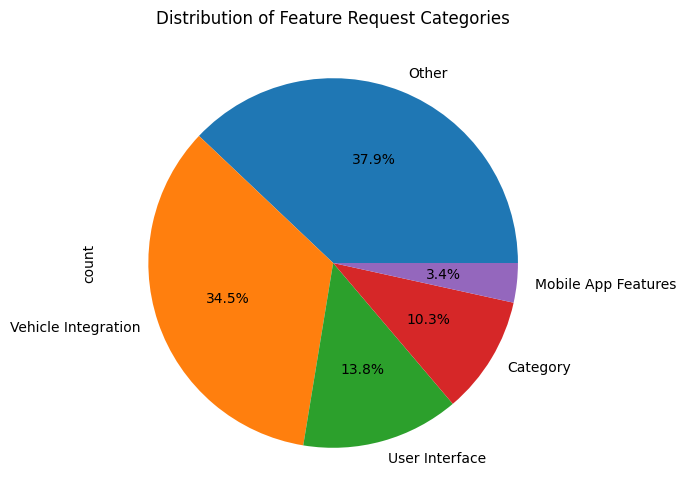


Top Requested Features by Category:

Vehicle Integration:
- Allow users to select and customize unit settings for distance, speed, and other metrics within the app. (1 requests)
- Difficulty in Adding Charging Account Across Different Versions

Choose category from:
- Vehicle Integration
- Mobile App Features
- Connected Services
- User Interface
- Other

The summary should a one-line description of the request.

The review text: "Issue with adding charging account from either charge on go/conclude or services get/account. Unistalled reinstalled. Changed tariff. Latest version 2.12.3" (1 requests)
- The user is requesting the addition of features such as a fuel level indicator and tire pressure gauge in the app. (1 requests)

Mobile App Features:
- The user is having trouble logging into the app after reinstalling it due to intermittent Internet connection issues.

Choose category from:
- Vehicle Integration
- Mobile App Features
- Connected Services
- User Interface
- Other (1 reques

In [21]:
# Cell [19]
# ======================================
# 20. Feature Request Analysis
# ======================================

def analyze_feature_requests():
    # Filter reviews containing feature requests
    feature_requests = df2[df2['topics'].str.contains('Feature Requests', na=False)]
    
    # Use LLM to categorize and summarize feature requests
    def categorize_feature_request(text, model_name=ollama_model_name):
        prompt = f"""Analyze this feature request and provide a response in exactly this format:
        Category|Summary
        
        Choose category from:
        - Vehicle Integration
        - Mobile App Features
        - Connected Services
        - User Interface
        - Other
        
        The summary should be a one-line description of the request.
        
        Review text: "{text}"
        
        Remember to use exactly one pipe symbol (|) to separate category and summary.
        """
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        response = process.stdout.strip()
        
        # Handle cases where the response doesn't contain a pipe
        if '|' not in response:
            return 'Other', 'Uncategorized request'
            
        try:
            category, summary = response.split('|', 1)  # Split on first pipe only
            return category.strip(), summary.strip()
        except ValueError:
            return 'Other', 'Uncategorized request'
    
    # Apply categorization
    categorized_requests = []
    for _, row in feature_requests.iterrows():
        try:
            category, summary = categorize_feature_request(row['content_english'])
            categorized_requests.append({
                'category': category,
                'summary': summary,
                'original_text': row['content_english']
            })
        except Exception as e:
            print(f"Error processing review: {e}")
            continue
    
    if not categorized_requests:
        print("No feature requests found or all processing failed")
        return
    
    # Create DataFrame and analyze
    request_df = pd.DataFrame(categorized_requests)
    
    # Plot distribution of feature request categories
    plt.figure(figsize=(10, 6))
    request_df['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Feature Request Categories')
    plt.show()
    
    # Display top requested features by category
    print("\nTop Requested Features by Category:")
    for category in request_df['category'].unique():
        print(f"\n{category}:")
        category_requests = request_df[request_df['category'] == category]['summary'].value_counts().head(3)
        for req, count in category_requests.items():
            print(f"- {req} ({count} requests)")

analyze_feature_requests()

<Figure size 1200x600 with 0 Axes>

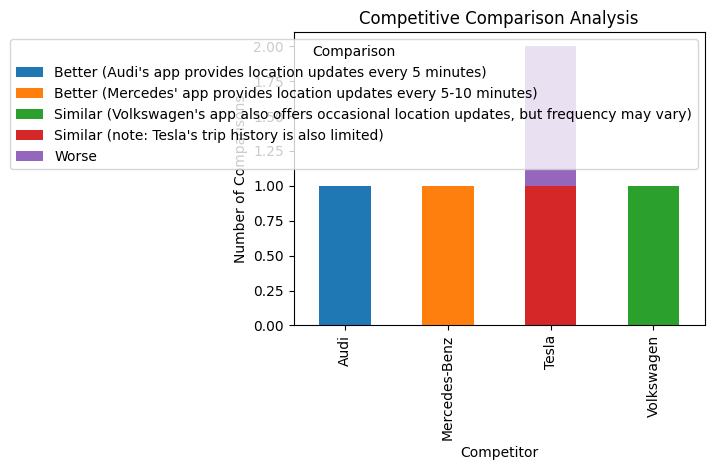


Detailed Feature Comparisons:

Tesla Comparisons:
comparison                   Similar (note: Tesla's trip history is also limited)  \
feature                                                                             
Location and status updates                                                  0      
Trip history                                                                 1      

comparison                   Worse  
feature                             
Location and status updates      1  
Trip history                     0  

Audi Comparisons:
comparison                   Better (Audi's app provides location updates every 5 minutes)
feature                                                                                   
Location and status updates                                                  1            

Mercedes-Benz Comparisons:
comparison                   Better (Mercedes' app provides location updates every 5-10 minutes)
feature                                    

In [22]:
# Cell [20]
# ======================================
# 21. User Pain Points Analysis
# ======================================

def analyze_feature_comparisons():
    """Use LLM to analyze how users compare the BMW app with competitors"""
    
    def extract_comparison(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review for any comparisons with other car manufacturer apps.
        Format response as: Competitor|Feature|Comparison
        Where Comparison is either 'Better', 'Worse', or 'Similar'
        
        Review: "{text}"
        
        Only output formatted lines if comparisons are found."""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Find reviews mentioning competitors
    competitor_keywords = ['tesla', 'mercedes', 'audi', 'porsche', 'volkswagen', 'vw']
    competitor_reviews = df2[df2['content_english'].str.lower().str.contains('|'.join(competitor_keywords), na=False)]
    
    comparisons = []
    for _, review in competitor_reviews.iterrows():
        try:
            comp_points = extract_comparison(review['content_english'])
            for point in comp_points:
                competitor, feature, comparison = point.split('|')
                comparisons.append({
                    'competitor': competitor.strip(),
                    'feature': feature.strip(),
                    'comparison': comparison.strip()
                })
        except Exception as e:
            continue
    
    if comparisons:
        comp_df = pd.DataFrame(comparisons)
        
        # Visualize comparisons
        plt.figure(figsize=(12, 6))
        comp_pivot = pd.crosstab(comp_df['competitor'], comp_df['comparison'])
        comp_pivot.plot(kind='bar', stacked=True)
        plt.title('Competitive Comparison Analysis')
        plt.xlabel('Competitor')
        plt.ylabel('Number of Comparisons')
        plt.legend(title='Comparison')
        plt.tight_layout()
        plt.show()
        
        # Print detailed feature comparisons
        print("\nDetailed Feature Comparisons:")
        for competitor in comp_df['competitor'].unique():
            print(f"\n{competitor} Comparisons:")
            competitor_features = comp_df[comp_df['competitor'] == competitor]
            print(pd.crosstab(competitor_features['feature'], competitor_features['comparison']))

analyze_feature_comparisons()

Processing 50 negative reviews...
Skipping response with wrong number of parts: Minor|None

Extracted 127 valid pain points


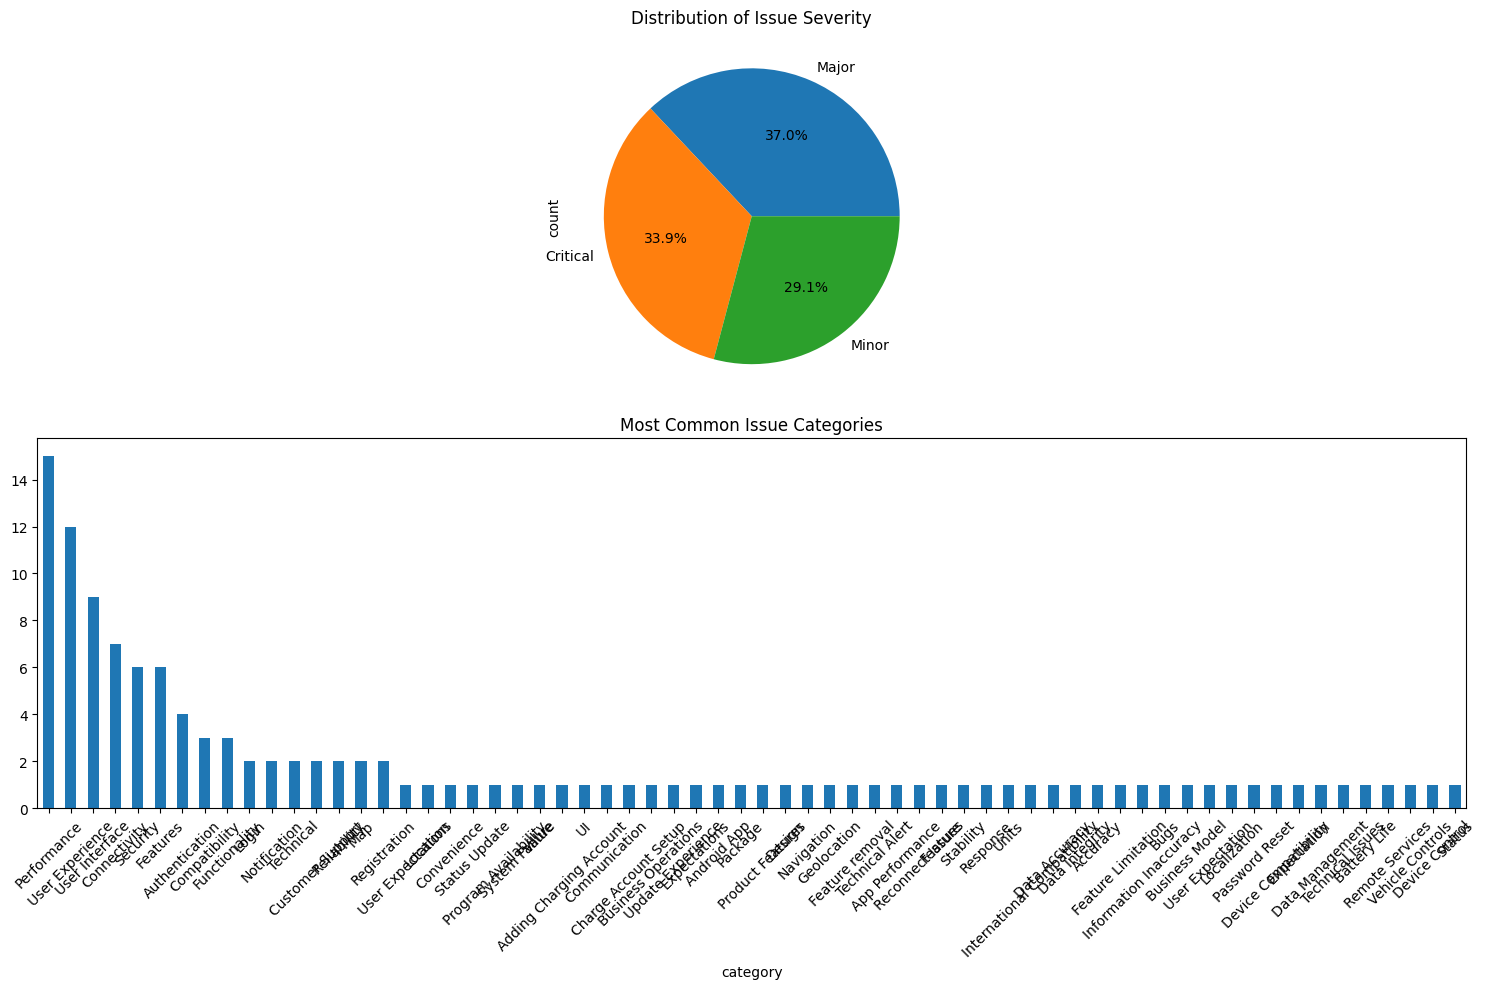


Top Issues by Severity:

Critical Issues:
issue
Cannot register due to app crashing at start page            1
Ventilation does not work anymore since the latest update    1
Car cannot be started                                        1
Name: count, dtype: int64

Major Issues:
issue
Text too small to read                                                                                        1
Issue persists after uninstalling and reinstalling, changing tariff, and updating to latest version 2.12.3    1
Windows cannot be opened or closed, no fuel level                                                             1
Name: count, dtype: int64

Minor Issues:
issue
No unit setting option                                        1
Updates always bring deterioration rather than improvement    1
Lack of spare key functionality in emergency situations       1
Name: count, dtype: int64


In [23]:
# Cell [21]
# ======================================
# 22. Pain Points Visualization
# ======================================

def analyze_user_pain_points():
    """Use LLM to identify and categorize specific user pain points"""
    
    def extract_pain_points(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review and identify specific user pain points.
        Format your response as: Severity|Category|Issue
        
        Severity levels: Critical, Major, Minor
        
        Review: "{text}"
        
        If multiple issues exist, list each on a new line.
        Only output the formatted lines, no additional text.
        
        Example output:
        Critical|Performance|App crashes during startup
        Major|Connectivity|Bluetooth connection unstable
        Minor|UI|Text too small to read"""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Analyze negative reviews
    negative_reviews = df2[df2['sentiment'] == 'Negative'].head(50)  # Note: 'Negative' not 'negative'
    all_pain_points = []
    
    print(f"Processing {len(negative_reviews)} negative reviews...")
    
    for idx, review in negative_reviews.iterrows():
        try:
            pain_points = extract_pain_points(review['content_english'])
            for point in pain_points:
                # Validate the format
                if '|' not in point:
                    print(f"Skipping invalid response: {point}")
                    continue
                    
                parts = point.split('|')
                if len(parts) != 3:
                    print(f"Skipping response with wrong number of parts: {point}")
                    continue
                    
                severity, category, issue = parts
                
                # Validate severity
                if severity.strip() not in ['Critical', 'Major', 'Minor']:
                    print(f"Skipping response with invalid severity: {severity}")
                    continue
                
                all_pain_points.append({
                    'severity': severity.strip(),
                    'category': category.strip(),
                    'issue': issue.strip()
                })
        except Exception as e:
            print(f"Error processing review: {e}")
            continue
    
    if not all_pain_points:
        print("No valid pain points were extracted from the reviews.")
        return
        
    pain_points_df = pd.DataFrame(all_pain_points)
    print(f"\nExtracted {len(pain_points_df)} valid pain points")
    
    # Visualize results
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    severity_counts = pain_points_df['severity'].value_counts()
    severity_counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Distribution of Issue Severity')
    
    plt.subplot(2, 1, 2)
    category_counts = pain_points_df['category'].value_counts()
    category_counts.plot(kind='bar')
    plt.title('Most Common Issue Categories')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print top issues by severity
    print("\nTop Issues by Severity:")
    for severity in ['Critical', 'Major', 'Minor']:
        matching_issues = pain_points_df[pain_points_df['severity'] == severity]
        if not matching_issues.empty:
            print(f"\n{severity} Issues:")
            print(matching_issues['issue'].value_counts().head(3))
        else:
            print(f"\nNo {severity} issues found")

analyze_user_pain_points()


=== Competitive Comparison Analysis ===


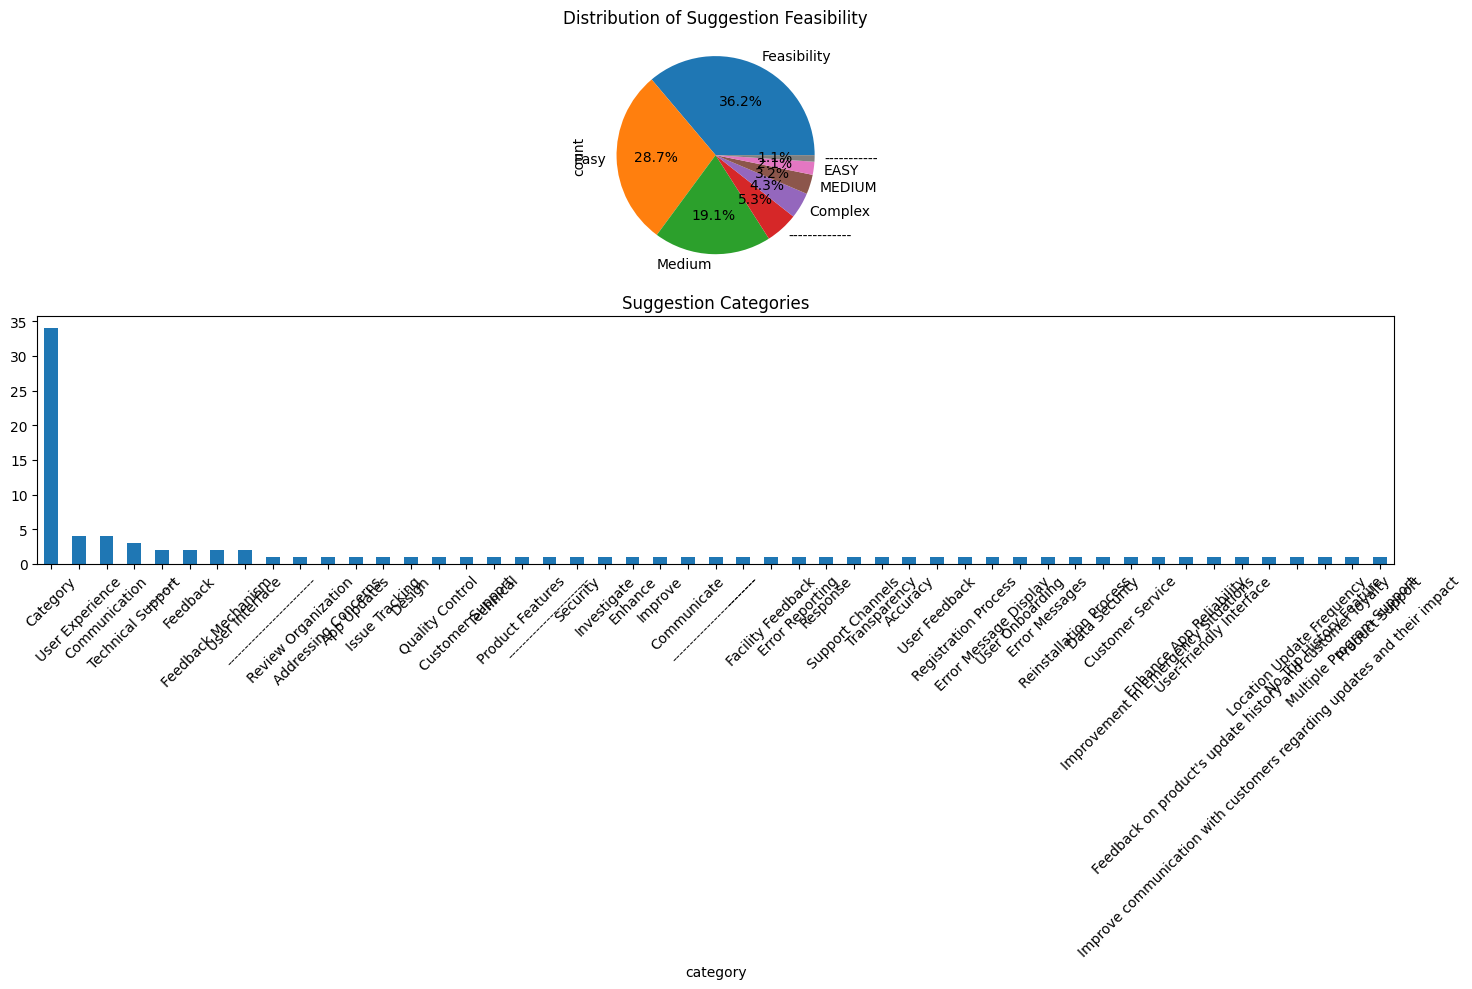


Top Suggestions by Feasibility:

Easy Implementation Suggestions:
suggestion
Provide regular updates with clear information about fixes and improvements                      1
Consider organizing review text into clear sections or bullet points for easier reading          1
Provide clear documentation on what causes password reset issues and how to troubleshoot them    1
Name: count, dtype: int64

Medium Implementation Suggestions:
suggestion
Improve crash reporting and user feedback mechanisms to quickly identify and address issues                   1
Clearly inform users of in-app errors and provide troubleshooting steps                                       1
Consider adding a notification or indicator on the top screen for low battery level updates or maintenance    1
Name: count, dtype: int64

Complex Implementation Suggestions:
suggestion
Implement a system to prevent accidental deletion or account lockout during uninstallation and reinstallation processes        1
Consider impl

In [24]:
# Cell [22]
# ======================================
# 23. Competitive Analysis
# ======================================

# Cell [23]
# ======================================
# 24. Improvement Suggestions Analysis
# ======================================
def analyze_feature_comparisons():
    """Use LLM to analyze how users compare the BMW app with competitors"""
    
    def extract_comparison(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review for any comparisons with other car manufacturer apps.
        Format response as: Competitor|Feature|Comparison
        Where Comparison is either 'Better', 'Worse', or 'Similar'
        
        Review: "{text}"
        
        Only output formatted lines if comparisons are found."""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Find reviews mentioning competitors
    competitor_keywords = ['tesla', 'mercedes', 'audi', 'porsche', 'volkswagen', 'vw']
    competitor_reviews = df2[df2['content_english'].str.lower().str.contains('|'.join(competitor_keywords), na=False)]
    
    comparisons = []
    for _, review in competitor_reviews.iterrows():
        try:
            comp_points = extract_comparison(review['content_english'])
            for point in comp_points:
                competitor, feature, comparison = point.split('|')
                comparisons.append({
                    'competitor': competitor.strip(),
                    'feature': feature.strip(),
                    'comparison': comparison.strip()
                })
        except Exception as e:
            continue
    
    if comparisons:
        comp_df = pd.DataFrame(comparisons)
        
        # Visualize comparisons
        plt.figure(figsize=(12, 6))
        comp_pivot = pd.crosstab(comp_df['competitor'], comp_df['comparison'])
        comp_pivot.plot(kind='bar', stacked=True)
        plt.title('Competitive Comparison Analysis')
        plt.xlabel('Competitor')
        plt.ylabel('Number of Comparisons')
        plt.legend(title='Comparison')
        plt.tight_layout()
        plt.show()
        
        # Print detailed feature comparisons
        print("\nDetailed Feature Comparisons:")
        for competitor in comp_df['competitor'].unique():
            print(f"\n{competitor} Comparisons:")
            competitor_features = comp_df[comp_df['competitor'] == competitor]
            print(pd.crosstab(competitor_features['feature'], competitor_features['comparison']))

    """Use LLM to analyze and categorize user suggestions for improvement"""


    def extract_suggestions(text, model_name=ollama_model_name):
        prompt = f"""Analyze this review for constructive suggestions for improvement.
        Format response as: Category|Suggestion|Feasibility
        Where Feasibility is 'Easy', 'Medium', or 'Complex'
        
        Review: "{text}"
        
        Only output actionable suggestions, one per line."""
        
        process = subprocess.run(
            ["ollama", "run", model_name],
            input=prompt,
            text=True,
            capture_output=True
        )
        
        return [line.strip() for line in process.stdout.strip().split('\n') if line.strip()]
    
    # Analyze reviews with constructive feedback
    constructive_reviews = df2[df2['content_english'].str.len() > 100]  # Focus on longer reviews
    suggestions = []
    
    for _, review in constructive_reviews.head(50).iterrows():  # Limit to 50 for demo
        try:
            suggs = extract_suggestions(review['content_english'])
            for sugg in suggs:
                category, suggestion, feasibility = sugg.split('|')
                suggestions.append({
                    'category': category.strip(),
                    'suggestion': suggestion.strip(),
                    'feasibility': feasibility.strip()
                })
        except Exception as e:
            continue
    
    if suggestions:
        sugg_df = pd.DataFrame(suggestions)
        
        # Visualize suggestions by feasibility
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 1, 1)
        feasibility_counts = sugg_df['feasibility'].value_counts()
        feasibility_counts.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Distribution of Suggestion Feasibility')
        
        plt.subplot(2, 1, 2)
        category_counts = sugg_df['category'].value_counts()
        category_counts.plot(kind='bar')
        plt.title('Suggestion Categories')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Print top suggestions by feasibility
        print("\nTop Suggestions by Feasibility:")
        for feasibility in ['Easy', 'Medium', 'Complex']:
            print(f"\n{feasibility} Implementation Suggestions:")
            feasible_suggs = sugg_df[sugg_df['feasibility'] == feasibility]
            print(feasible_suggs['suggestion'].value_counts().head(3))


print("\n=== Competitive Comparison Analysis ===")
analyze_feature_comparisons()


In [39]:
def generate_comprehensive_analysis_report(df2):
    """
    Generates a comprehensive analysis report with full text display.
    """
    # Set pandas display options
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)

    def format_section(title, content):
        return f"\n{'='*50}\n{title}\n{'='*50}\n{content}\n"
    
    def format_review(row):
        """Format a single review with all its details"""
        return f"""Rating: {row['score']}/5 | Date: {row['at'].strftime('%Y-%m-%d')}
Content: {row['content_english']}"""

    try:
        sections = []
        
        # 1. Executive Summary
        exec_summary = f"""
Analysis Period: {df2['at'].min().strftime('%Y-%m-%d')} to {df2['at'].max().strftime('%Y-%m-%d')}
Total Reviews: {len(df2)}
Overall Rating: {df2['score'].mean():.2f}/5.0

Sentiment Distribution:
---------------------
{df2['sentiment'].value_counts().to_string()}

Rating Distribution:
-----------------
{df2['score'].value_counts().sort_index().to_string()}
"""
        sections.append(format_section("1. EXECUTIVE SUMMARY", exec_summary))
        
        # 2. Sentiment Analysis
        sentiment_analysis = f"""
Average Rating by Sentiment:
-------------------------
{df2.groupby('sentiment')['score'].mean().round(2).to_string()}

Example Reviews by Sentiment:
--------------------------
"""
        for sentiment in ['Positive', 'Negative', 'Neutral']:
            sentiment_reviews = df2[df2['sentiment'] == sentiment].head(3)
            sentiment_analysis += f"\n{sentiment} Reviews (Top 3):\n"
            for _, row in sentiment_reviews.iterrows():
                sentiment_analysis += format_review(row) + "\n\n"
        
        sections.append(format_section("2. SENTIMENT ANALYSIS", sentiment_analysis))
        
        # 3. Topic Analysis
        topics_expanded = df2['topics'].str.split(',').explode()
        topic_counts = topics_expanded.value_counts()
        
        topic_analysis = f"""
Most Common Topics:
----------------
{topic_counts.head(10).to_string()}

Example Reviews by Top Topics:
--------------------------
"""
        for topic in topic_counts.head(5).index:
            topic_reviews = df2[df2['topics'].str.contains(topic, na=False)].head(3)
            topic_analysis += f"\n{topic}:\n"
            for _, row in topic_reviews.iterrows():
                topic_analysis += format_review(row) + "\n\n"
        
        sections.append(format_section("3. TOPIC ANALYSIS", topic_analysis))
        
        # 4. Critical Issues
        negative_reviews = df2[df2['score'] <= 2]
        critical_analysis = f"""
Critical Issues Overview:
----------------------
Total Critical Reviews: {len(negative_reviews)}
Percentage of Total: {(len(negative_reviews)/len(df2)*100):.1f}%

Representative Critical Issues:
---------------------------
"""
        for score in [1, 2]:
            score_reviews = negative_reviews[negative_reviews['score'] == score].head(3)
            critical_analysis += f"\n{score}-Star Reviews:\n"
            for _, row in score_reviews.iterrows():
                critical_analysis += format_review(row) + "\n\n"
        
        sections.append(format_section("4. CRITICAL ISSUES", critical_analysis))
        
        # Combine all sections
        full_report = "\nBMW CONNECTED APP REVIEW ANALYSIS - COMPREHENSIVE REPORT\n" + \
                     f"Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n" + \
                     "".join(sections)
        
        # Save report
        output_file = "bmw_app_comprehensive_analysis_report.txt"
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(full_report)
        
        print(f"Comprehensive report generated and saved to {output_file}")
        return full_report

    except Exception as e:
        print(f"Error generating report: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Generate the comprehensive report
comprehensive_report = generate_comprehensive_analysis_report(df2)

Comprehensive report generated and saved to bmw_app_comprehensive_analysis_report.txt
